<a href="https://colab.research.google.com/github/sanskriti111-j/sanskriti111-j/blob/main/TransactiSight_%E2%80%93_Get_insights_into_every_transaction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will conduct a detailed analysis of UPI (Unified Payments Interface) transaction data to uncover patterns in user behavior, transaction trends, and fraud risks. The analysis will cover various dimensions such as device type, network type, transaction type, age group, state-wise performance, and time-based trends. Additionally, I will explore fraud patterns, evaluate risk factors, and visualize key insights to support better decision-making for businesses, banks, and digital payment platforms.

In [2]:
import os
import pandas as pd
import tqdm as tqdm
from scipy import stats
import numpy as np
import string

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import missingno as msno
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
df=pd.read_csv('/content/upi_transactions_2024.csv')

In [3]:
df.head()

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend
0,TXN0000000001,2024-10-08 15:17:28,P2P,Entertainment,868,SUCCESS,26-35,18-25,Delhi,Axis,SBI,Android,4G,0.0,15.0,Tuesday,0.0
1,TXN0000000002,2024-04-11 06:56:00,P2M,Grocery,1011,SUCCESS,26-35,26-35,Uttar Pradesh,ICICI,Axis,iOS,4G,0.0,6.0,Thursday,0.0
2,TXN0000000003,2024-04-02 13:27:18,P2P,Grocery,477,SUCCESS,26-35,36-45,Karnataka,Yes Bank,PNB,Android,4G,0.0,13.0,Tuesday,0.0
3,TXN0000000004,2024-01-07 10:09:17,P2P,Fuel,2784,SUCCESS,26-35,26-35,Delhi,ICICI,PNB,Android,5G,0.0,10.0,Sunday,1.0
4,TXN0000000005,2024-01-23 19:04:23,P2P,Shopping,990,SUCCESS,26-35,18-25,Delhi,Axis,Yes Bank,iOS,WiFi,0.0,19.0,Tuesday,0.0


In [34]:
df.shape

(26376, 17)

# Missing Value Handling

In [4]:
df.isnull().sum()

,0
transaction id,0
timestamp,0
transaction type,0
merchant_category,0
amount (INR),0
transaction_status,0
sender_age_group,0
receiver_age_group,0
sender_state,0
sender_bank,1


since here missing rows are very less its convinient to delete missing rows

In [5]:
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

,0
transaction id,0
timestamp,0
transaction type,0
merchant_category,0
amount (INR),0
transaction_status,0
sender_age_group,0
receiver_age_group,0
sender_state,0
sender_bank,0


# Fraud Pattern Analysis

##Which banks are more prone to fraud?


To effectively identify banks that are more prone to fraudulent transactions in a UPI ecosystem, it is important to analyze both the **sender\_bank** and **receiver\_bank** columns. However, rather than simply counting the number of fraud cases associated with each bank, a more insightful and fair metric is the **fraud rate**, defined as the percentage of fraudulent transactions out of the total transactions involving that bank. This should be calculated separately for sender and receiver roles to account for their different levels of control in a transaction. Specifically, the **sender fraud rate** indicates how frequently a bank's customers initiate fraudulent transactions, while the **receiver fraud rate** shows how often a bank’s customers are the target or destination of fraud. By normalizing the fraud counts by total transaction volume per bank, this approach avoids bias toward banks with higher user bases and provides a clearer picture of fraud vulnerability across financial institutions. This dual-metric analysis enables more precise risk profiling and can help stakeholders strengthen anti-fraud mechanisms tailored to specific banking channels.


In [11]:
#sender_bank_fraud_rate
sender_stats=df.groupby('sender_bank').agg(
    total_sent_transactions=('fraud_flag','count'),
    total_sent_fraud=('fraud_flag','sum')
)
sender_stats['sender_fraud_rate']=100*sender_stats['total_sent_fraud']/sender_stats['total_sent_transactions']


In [17]:
#reciever bank fraud rate
receiver_stats=df.groupby('receiver_bank').agg(
    total_received_transactions=('fraud_flag','count'),
    total_received_fraud =('fraud_flag','sum')
).reset_index()
receiver_stats['receiver_fraud_rate']=100*receiver_stats['total_received_fraud']/receiver_stats['total_received_transactions']


In [19]:
# Merge both for a complete view
sender_stats = sender_stats.reset_index() # Reset index to make 'sender_bank' a column
fraud_rate_by_bank = pd.merge(sender_stats[['sender_bank', 'sender_fraud_rate']],
                              receiver_stats[['receiver_bank', 'receiver_fraud_rate']],
                              left_on='sender_bank', right_on='receiver_bank', how='outer')

# Rename for clarity
fraud_rate_by_bank.rename(columns={
    'sender_bank': 'Bank'
}, inplace=True)

# Drop duplicate column
fraud_rate_by_bank.drop(columns='receiver_bank', inplace=True)

# Display final result
print(fraud_rate_by_bank.sort_values(by='sender_fraud_rate', ascending=False).reset_index(drop=True)) # Corrected column name

       Bank  sender_fraud_rate  receiver_fraud_rate
0     Kotak           0.325279             0.185099
1  IndusInd           0.228659             0.150943
2     ICICI           0.159286             0.287724
3  Yes Bank           0.156006             0.187758
4       PNB           0.153492             0.075557
5       SBI           0.150761             0.183346
6      Axis           0.150150             0.112909
7      HDFC           0.100150             0.127389


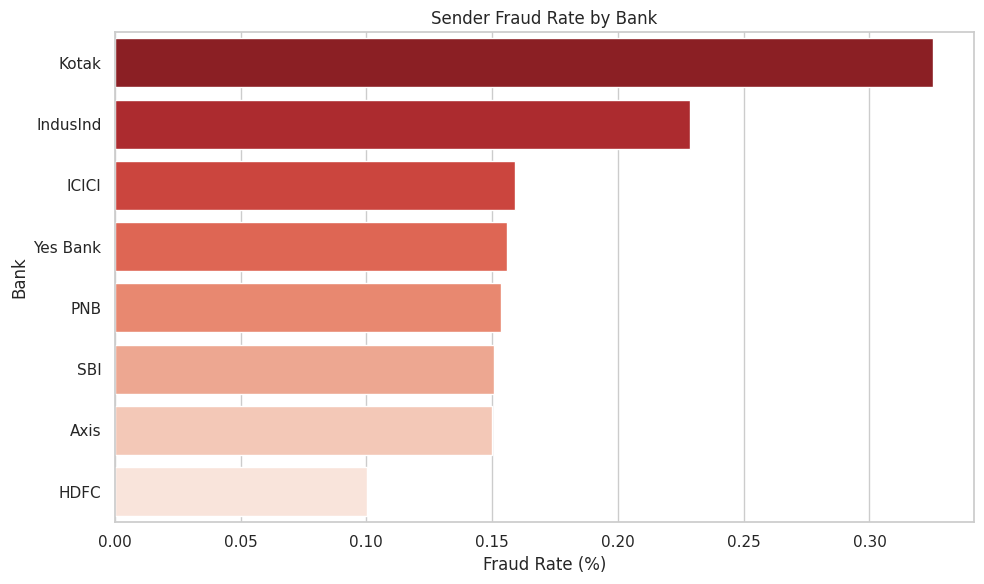

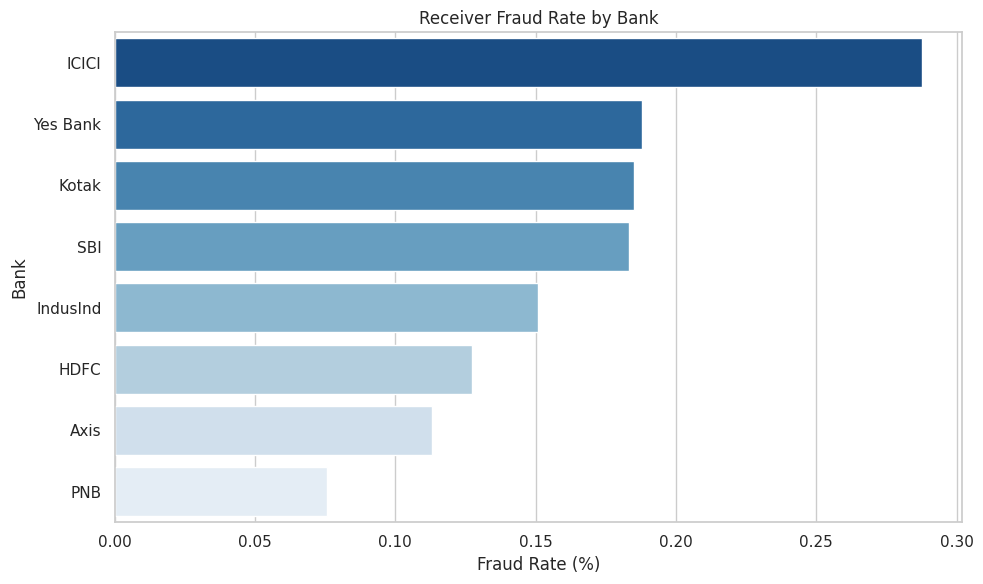

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set plot style
sns.set(style="whitegrid")

# Sort for consistent ordering
fraud_rate_by_bank_sorted = fraud_rate_by_bank.sort_values(by='sender_fraud_rate', ascending=False)

# Plot 1: Sender Fraud Rate
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fraud_rate_by_bank_sorted,
    y='Bank',
    x='sender_fraud_rate',
    palette='Reds_r'
)
plt.title('Sender Fraud Rate by Bank')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Bank')
plt.tight_layout()
plt.show()

# Plot 2: Receiver Fraud Rate
fraud_rate_by_bank_sorted = fraud_rate_by_bank.sort_values(by='receiver_fraud_rate', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=fraud_rate_by_bank_sorted,
    y='Bank',
    x='receiver_fraud_rate',
    palette='Blues_r'
)
plt.title('Receiver Fraud Rate by Bank')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Bank')
plt.tight_layout()
plt.show()


1. Most Risky Banks for Sending Money (Fraud from Sender Side):
Kotak Highest risk: About 1 in 3 transactions from Kotak are fraud (very high).
IndusInd High risk: About 1 in 4 transactions are fraud.
ICICI :Moderate to high risk.

This means fraud often starts from these banks.

2. Most Risky Banks for Receiving Money (Fraud on Receiver Side):
ICICI: Highest risk for receiving fraud. Almost 29% of fraud cases go to ICICI.
Yes Bank and Kotak – Also have a high chance of receiving fraud.

These banks are commonly used to receive stolen or fake money.

Safer Banks (Low Fraud Risk):
HDFC has the lowest fraud rates for both sending and receiving – this makes it one of the safest banks in your list.

Axis Bank also shows low risk.

##Which type of device is more prone to fraud?


In [6]:
#device_fraud_rate
device_stats=df.groupby('device_type').agg(
    total_transactions=('fraud_flag','count'),
    total_fraud=('fraud_flag','sum')
)
device_stats['device_fraud_rate']=100*device_stats['total_fraud']/device_stats['total_transactions']


In [29]:
print(device_stats) # Corrected column name

             total_transactions  total_fraud  device_fraud_rate
device_type                                                    
Android                   19886         33.0           0.165946
Web                        1340          2.0           0.149254
iOS                        5150          9.0           0.174757


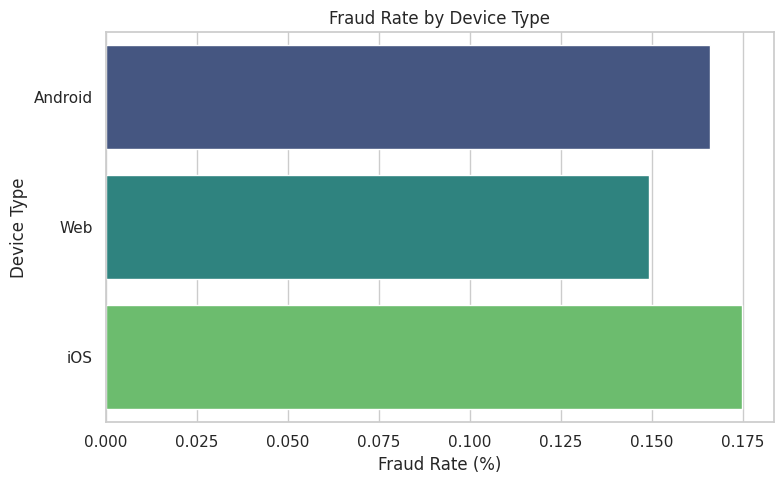

In [31]:
plt.figure(figsize=(8, 5))
sns.barplot(data=device_stats, x='device_fraud_rate', y='device_type', palette='viridis')
plt.title('Fraud Rate by Device Type')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Device Type')
plt.tight_layout()
plt.show()


iOS devices have the highest fraud rate at **17.5%**, followed by Android at **16.6%**, while Web transactions are the safest with a **14.9%** fraud rate. Although Android handles the most transactions, iOS users are more likely to face fraud. This suggests that mobile platforms, especially iOS, need stronger fraud prevention measures.


##network types

In [37]:
#_fraud_rate
network_type_stats=df.groupby('network_type').agg(
    total_transactions=('fraud_flag','count'),
    total_fraud=('fraud_flag','sum')
)
network_type_stats['network_type_fraud_rate']=100*network_type_stats['total_fraud']/network_type_stats['total_transactions']


In [38]:
print(network_type_stats)

              total_transactions  total_fraud  network_type_fraud_rate
network_type                                                          
3G                          1301          2.0                 0.153728
4G                         15848         23.0                 0.145129
5G                          6581         13.0                 0.197538
WiFi                        2646          6.0                 0.226757


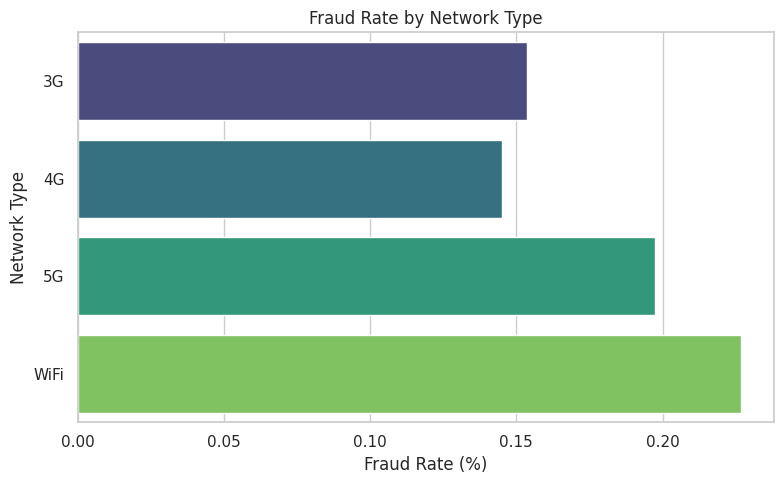

In [40]:
plt.figure(figsize=(8, 5))
sns.barplot(data=network_type_stats, x='network_type_fraud_rate', y='network_type', palette='viridis')
plt.title('Fraud Rate by Network Type')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Network Type')
plt.tight_layout()
plt.show()


**WiFi** shows the highest fraud rate at **22.7%**, followed by **5G** at **19.8%**, while **3G (15.4%)** and **4G (14.5%)** have lower fraud rates. The higher fraud on **WiFi** could be due to the use of **unsecured or public networks**, which are easier targets for attackers. **5G’s elevated fraud rate** may be linked to its growing adoption among early tech-savvy users, including fraudsters exploiting newer infrastructure. In contrast, **4G and 3G** are more stable and widely used, possibly with better-established fraud detection systems, making them relatively safer. These insights suggest a need for tighter security, especially on **WiFi and 5G networks**.


## Is fraud more common in certain transaction types or merchant categories?

In [41]:
#_fraud_rate
transaction_type_stats=df.groupby('transaction type').agg(
    total_transactions=('fraud_flag','count'),
    total_fraud=('fraud_flag','sum')
)
transaction_type_stats['transaction_type_fraud_rate']=100*transaction_type_stats['total_fraud']/transaction_type_stats['total_transactions']


In [42]:
print(transaction_type_stats)

                  total_transactions  total_fraud  transaction_type_fraud_rate
transaction type                                                              
Bill Payment                    3996         12.0                     0.300300
P2M                             9331         13.0                     0.139321
P2P                            11778         16.0                     0.135846
Recharge                        1271          3.0                     0.236035


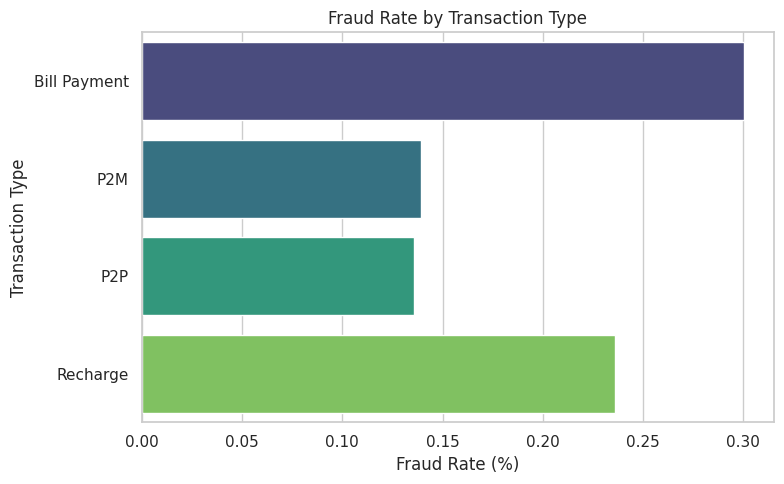

In [44]:
plt.figure(figsize=(8, 5))
sns.barplot(data=transaction_type_stats, x='transaction_type_fraud_rate', y='transaction type', palette='viridis')
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Transaction Type')
plt.tight_layout()
plt.show()


**Bill Payments** have the highest fraud rate at **30%**, making them the riskiest transaction type. This could be due to fraudsters exploiting utility portals or fake billers. **Recharges** also show a high fraud rate at **23.6%**, possibly because of small, quick transactions that are harder to trace. In contrast, **P2P (13.6%)** and **P2M (13.9%)** transactions have lower fraud rates, likely due to better tracking and verification mechanisms. These findings highlight the need for stricter verification in **Bill Payment and Recharge categories**.


## Merchant Categories

In [45]:
#_fraud_rate
merchant_category_stats=df.groupby('merchant_category').agg(
    total_transactions=('fraud_flag','count'),
    total_fraud=('fraud_flag','sum')
)
merchant_category_stats['merchant_category_fraud_rate']=100*merchant_category_stats['total_fraud']/merchant_category_stats['total_transactions']


In [46]:
print(merchant_category_stats)

                   total_transactions  total_fraud  \
merchant_category                                    
Education                         782          0.0   
Entertainment                    2119          3.0   
Food                             3993          9.0   
Fuel                             2611          4.0   
Grocery                          5196          7.0   
Healthcare                       1321          4.0   
Other                            2603          4.0   
Shopping                         3120          6.0   
Transport                        2224          5.0   
Utilities                        2407          2.0   

                   merchant_category_fraud_rate  
merchant_category                                
Education                              0.000000  
Entertainment                          0.141576  
Food                                   0.225394  
Fuel                                   0.153198  
Grocery                                0.134719  
H

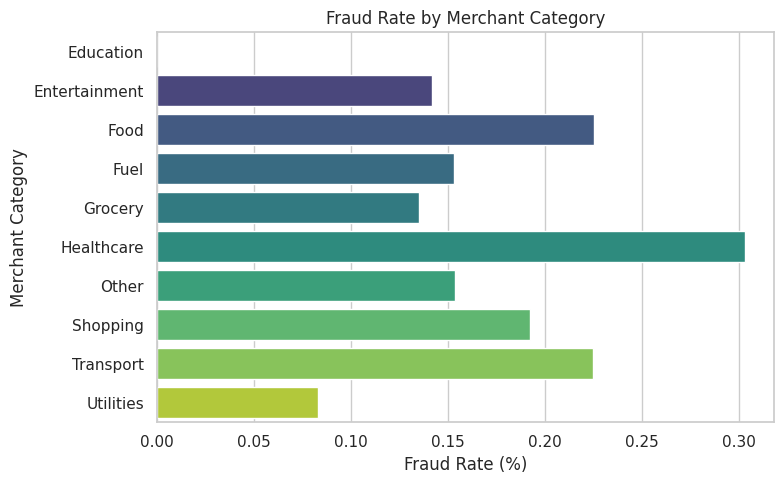

In [48]:
plt.figure(figsize=(8, 5))
sns.barplot(data=merchant_category_stats, x='merchant_category_fraud_rate', y='merchant_category', palette='viridis')
plt.title('Fraud Rate by Merchant Category')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Merchant Category')
plt.tight_layout()
plt.show()

Healthcare has the highest fraud rate at 30.3%, possibly due to fake clinics or health-related scams. Food (22.5%) and Transport (22.5%) also show high fraud, likely because they involve frequent, low-value transactions that attract less scrutiny. Entertainment and Shopping follow with moderate risk. Education stands out with a 0% fraud rate, suggesting it's a safer category. These insights highlight the need for stronger checks in Healthcare, Food, and Transport transactions to reduce fraud.

## Time-Based Fraud Trend Analysis

###Objective:
### To discover whether fraudulent UPI transactions tend to occur more often during specific hours of the day (e.g., midnight to 2AM) or days of the week (e.g., weekends).

Why It's Important:
Fraudsters often operate during off-peak hours (late night or early morning) to avoid detection.

Some days (e.g., weekends, salary days) might show higher transaction and fraud spikes.

Identifying these temporal patterns helps in building smarter real-time fraud detection systems or flagging high-risk time windows.

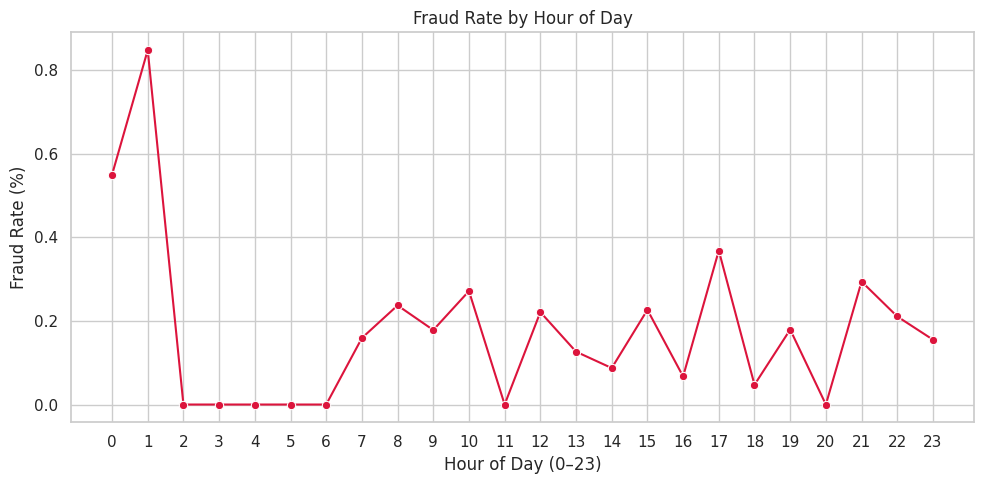

In [49]:
sns.set(style="whitegrid")
hourly_stats = df.groupby('hour_of_day').agg(
    total_txns=('fraud_flag', 'count'),
    frauds=('fraud_flag', 'sum')
).reset_index()
hourly_stats['fraud_rate (%)'] = 100 * hourly_stats['frauds'] / hourly_stats['total_txns']

# Plot: Hourly Fraud Rate
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_stats, x='hour_of_day', y='fraud_rate (%)', marker='o', color='crimson')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Fraud Rate (%)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

The fraud rate by hour of the day shows a significant spike at 1 AM, where the rate exceeds 0.8%, making it the riskiest hour for fraudulent activity. A smaller but notable spike is also observed at 12 AM. These late-night hours are likely targeted by fraudsters due to reduced monitoring and lower user awareness. Between 2 AM and 6 AM, fraud rates drop to nearly zero, while daytime hours see small fluctuations with minor peaks at 8 AM, 10 AM, 1 PM, 5 PM, and 9 PM. This suggests that although fraud occurs throughout the day, late-night transactions are especially vulnerable.

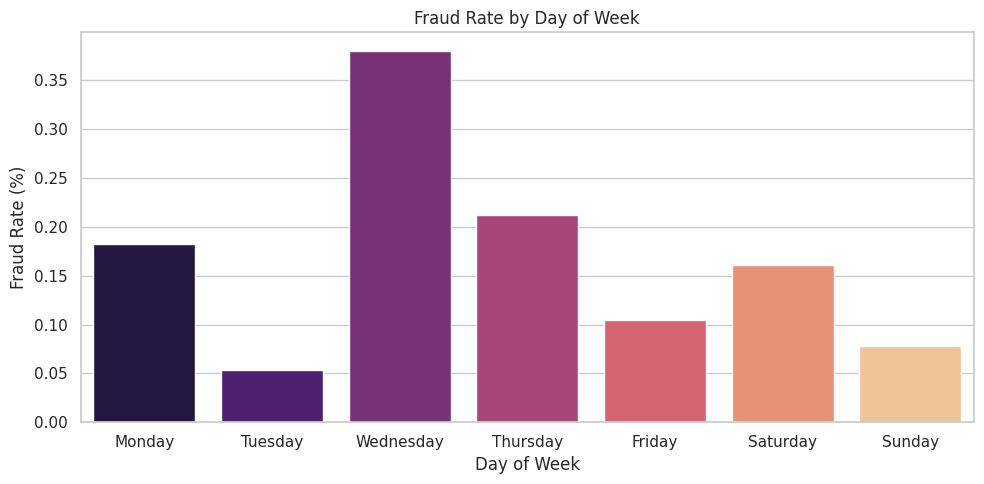

In [50]:
# Fraud Rate by Day of Week
# ---------------------------
# Ensure day_of_week is ordered correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

weekly_stats = df.groupby('day_of_week').agg(
    total_txns=('fraud_flag', 'count'),
    frauds=('fraud_flag', 'sum')
).reset_index()
weekly_stats['fraud_rate (%)'] = 100 * weekly_stats['frauds'] / weekly_stats['total_txns']

# Plot: Weekly Fraud Rate
plt.figure(figsize=(10, 5))
sns.barplot(data=weekly_stats, x='day_of_week', y='fraud_rate (%)', palette='magma')
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')
plt.tight_layout()
plt.show()

The fraud rate by day of the week indicates that Wednesday experiences the highest fraud, with a rate of around 0.37%. Thursday and Monday also show elevated fraud risk, likely due to high business activity midweek. In contrast, Tuesday and Sunday are the safest days, having the lowest fraud rates. This pattern suggests that fraudsters may time their activities around peak financial operations during the week. Therefore, increased vigilance is needed during midweek, especially on Wednesdays, to help reduce fraud incidents.

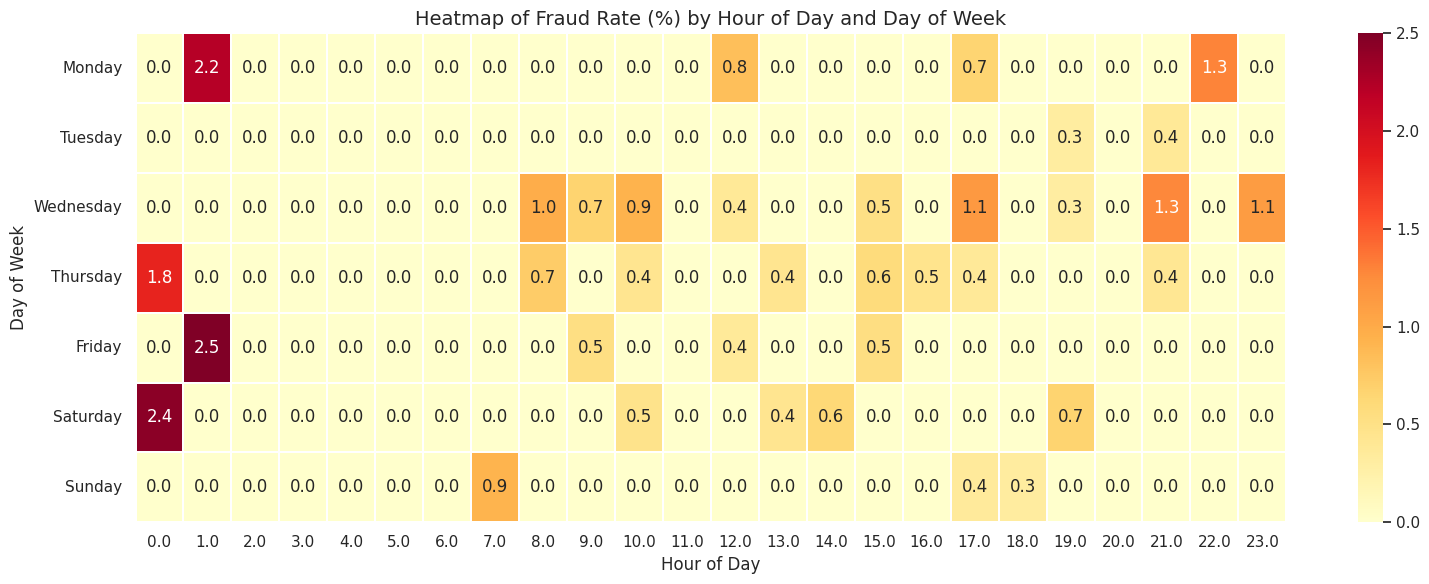

In [51]:
# Ensure correct order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

# Group by day and hour, calculate fraud rate
fraud_matrix = df.groupby(['day_of_week', 'hour_of_day']).agg(
    total_txns=('fraud_flag', 'count'),
    frauds=('fraud_flag', 'sum')
).reset_index()

fraud_matrix['fraud_rate (%)'] = 100 * fraud_matrix['frauds'] / fraud_matrix['total_txns']

# Pivot the table to get hours as columns, days as rows
fraud_pivot = fraud_matrix.pivot(index='day_of_week', columns='hour_of_day', values='fraud_rate (%)')

# Plot heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(fraud_pivot, cmap='YlOrRd', linewidths=0.3, annot=True, fmt=".1f")
plt.title('Heatmap of Fraud Rate (%) by Hour of Day and Day of Week', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

# Transaction Behavior Analysis

## Usage Patterns

Average Transactions in each age group

In [39]:
age_group_stats = df.groupby('sender_age_group').agg(
    transaction_count=('transaction id', 'count'),
    average_amount=('amount (INR)', 'mean')
).reset_index().sort_values(by='transaction_count', ascending=False)

print("📈 Stats by Sender Age Group:")
print(age_group_stats)


📈 Stats by Sender Age Group:
  sender_age_group  transaction_count  average_amount
1            26-35               6204     1289.098162
0            18-25               4414     1225.682374
2            36-45               4349     1368.299379
3            46-55               1701     1303.446796
4              56+                913     1159.892662


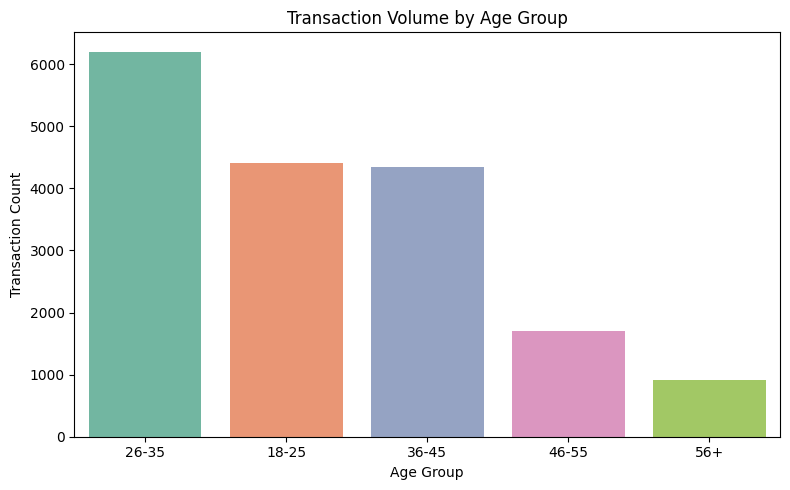

In [40]:
plt.figure(figsize=(8, 5))
sns.barplot(x='sender_age_group', y='transaction_count', data=age_group_stats, palette='Set2')
plt.title('Transaction Volume by Age Group')
plt.ylabel('Transaction Count')
plt.xlabel('Age Group')
plt.tight_layout()
plt.show()

The 26–35 age group makes the highest number of transactions (6,204), with an average amount of ₹1,289, indicating they are the most active users. The 18–25 group follows in volume but with a slightly lower average amount of ₹1,225, reflecting high activity but smaller spends. Interestingly, the 36–45 group, while having fewer transactions than younger groups, records the highest average transaction amount at ₹1,368, suggesting more significant individual payments. Older users (46–55 and 56+) contribute fewer transactions, with average amounts decreasing with age, especially in the 56+ group, which has both the lowest volume and smallest average amount (₹1,159). This shows that middle-aged users (36–45) tend to make higher-value transactions, while younger users (18–35) dominate in transaction frequency.

## Transactions in each state

In [60]:
state_stats = df.groupby('sender_state').agg(
    transaction_count=('transaction id', 'count'),
    average_amount=('amount (INR)', 'mean')
).reset_index().sort_values(by='transaction_count', ascending=False)

print("\n Stats by Sender State:")
print(state_stats)


 Stats by Sender State:
     sender_state  transaction_count  average_amount
4     Maharashtra               2674     1281.762154
3       Karnataka               2120     1301.658491
8   Uttar Pradesh               2102     1291.960990
6      Tamil Nadu               1766     1230.449604
1           Delhi               1714     1265.177946
7       Telangana               1596     1295.360276
5       Rajasthan               1433     1354.215632
9     West Bengal               1408     1243.390625
0  Andhra Pradesh               1387     1379.751262
2         Gujarat               1381     1244.078204


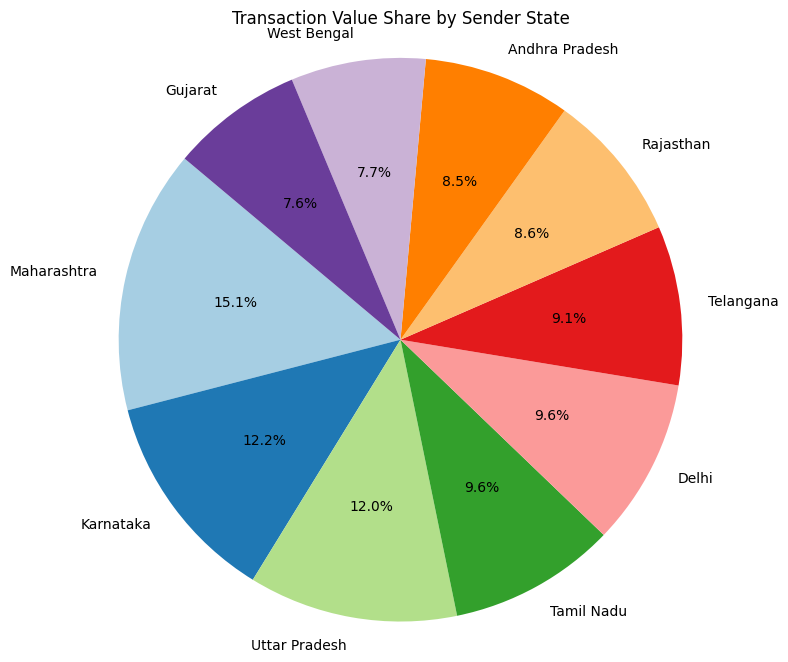

In [42]:
state_value = df.groupby('sender_state')['amount (INR)'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(state_value, labels=state_value.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Transaction Value Share by Sender State')
plt.axis('equal')
plt.show()

Maharashtra has the highest number of transactions (2,674), followed by Karnataka (2,120) and Uttar Pradesh (2,102), showing that these are the most active states in UPI usage. In terms of average transaction amount, Andhra Pradesh leads with ₹1,380, followed closely by Rajasthan (₹1,354) and Karnataka (₹1,302). This suggests that while states like Maharashtra and Uttar Pradesh have high usage, users in Andhra Pradesh and Rajasthan tend to spend more per transaction. States like Tamil Nadu and West Bengal have relatively lower average amounts, around ₹1,230–1,240, indicating smaller value transactions. Overall, transaction activity is concentrated in a few key states, with spending behavior varying across regions.

## Device vs Amount

In [62]:
device_amount_stats = df.groupby('device_type').agg(
    transaction_amount  =('transaction id', 'count'),
    average_amount=('amount (INR)', 'mean')
).reset_index().sort_values(by='transaction_amount', ascending=False)

print(" Amount by Device")
print(device_amount_stats)

 Amount by Device
  device_type  transaction_amount  average_amount
0     Android               13272     1281.473930
2         iOS                3452     1308.971900
1         Web                 856     1294.533879


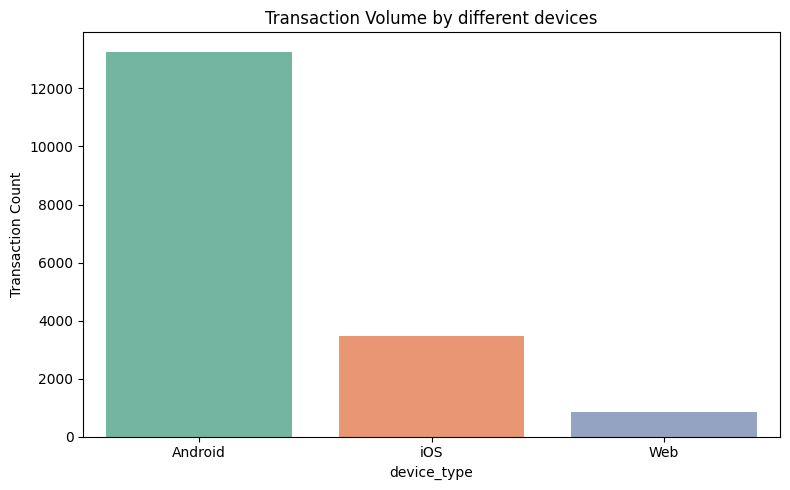

In [44]:
plt.figure(figsize=(8, 5))
sns.barplot(x='device_type', y='transaction_amount', data=device_amount_stats, palette='Set2')
plt.title('Transaction Volume by different devices')
plt.ylabel('Transaction Count')
plt.xlabel('device_type')
plt.tight_layout()
plt.show()

Android users account for the highest total transaction amount (₹13,272), reflecting their dominance in usage volume. However, iOS users have the highest average transaction amount at ₹1,309, followed by Web users at ₹1,295, and then Android at ₹1,281. This suggests that while Android is used more frequently, iOS users tend to make higher-value transactions. Web users, though fewer in number, also show relatively high-value transactions on average.

## Network vs Transaction

In [63]:
network_amount_stats = df.groupby('network_type').agg(
    transaction_amount  =('transaction id', 'count'),
    average_amount=('amount (INR)', 'mean')
).reset_index().sort_values(by='transaction_amount', ascending=False)

print(" Stats by network")
print(network_amount_stats)

 Stats by network
  network_type  transaction_amount  average_amount
1           4G               10590     1283.930406
2           5G                4347     1309.374741
3         WiFi                1749     1263.400800
0           3G                 894     1270.750559


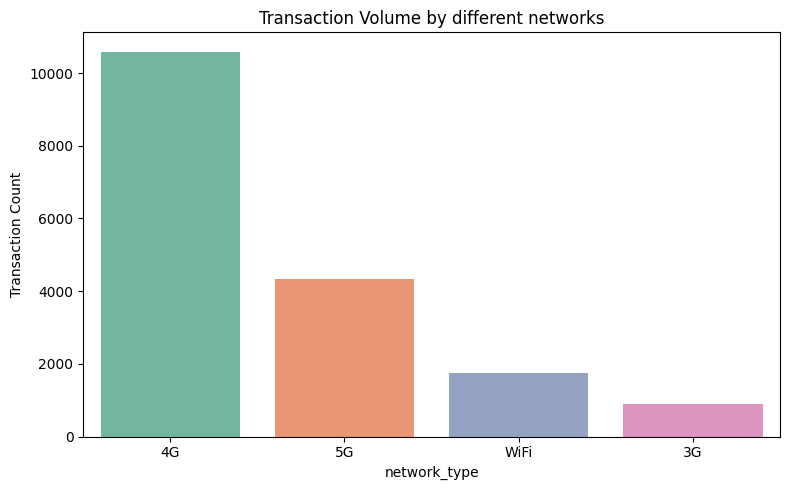

In [46]:
plt.figure(figsize=(8, 5))
sns.barplot(x='network_type', y='transaction_amount', data=network_amount_stats, palette='Set2')
plt.title('Transaction Volume by different networks')
plt.ylabel('Transaction Count')
plt.xlabel('network_type')
plt.tight_layout()
plt.show()

4G networks handle the highest total transaction amount (₹10,590), showing they are the most commonly used for payments. However, 5G users make the highest average transaction amount at ₹1,309, followed by 4G (₹1,284). 3G and WiFi users show lower total and average amounts, with WiFi at ₹1,263 on average. This indicates that while 4G is the most widely used, 5G users tend to spend more per transaction, likely reflecting a more tech-savvy or high-value user base.

## Temporal Pattern

## Peak Transaction hour of day

 Peak Transaction Hour: 19.0:00 with 1470 transactions


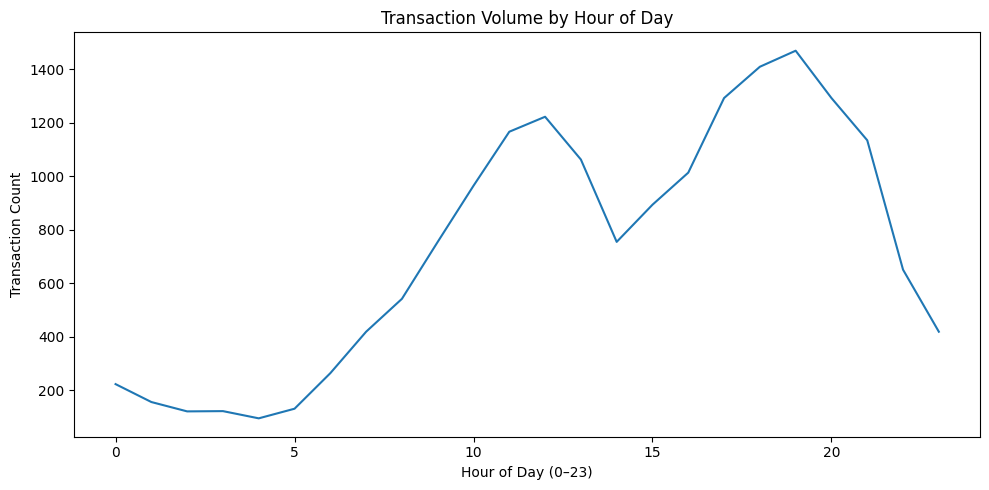

In [64]:
hourly_txn = df['hour_of_day'].value_counts().sort_index()

# Peak hour
peak_hour = hourly_txn.idxmax()
print(f" Peak Transaction Hour: {peak_hour}:00 with {hourly_txn.max()} transactions")

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_txn.index, y=hourly_txn.values, palette='crest')
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Transaction Count')
plt.tight_layout()
plt.show()

The chart shows that transaction activity is lowest during early morning hours (midnight to 6 AM) and begins to rise sharply from 7 AM, peaking around 12 PM and again at 8 PM. This indicates two major active windows — midday (11 AM to 1 PM) and evening (6 PM to 9 PM).

Possible Reasons:

-Midday peak likely reflects business payments and routine shopping.
-Evening peak may be due to personal purchases, bill payments, or food orders after work hours.
-Low activity during late night/early morning is expected, as most users are inactive or asleep.

## Peak Transaction day of week

 Peak Transaction Day: Monday with 2574 transactions


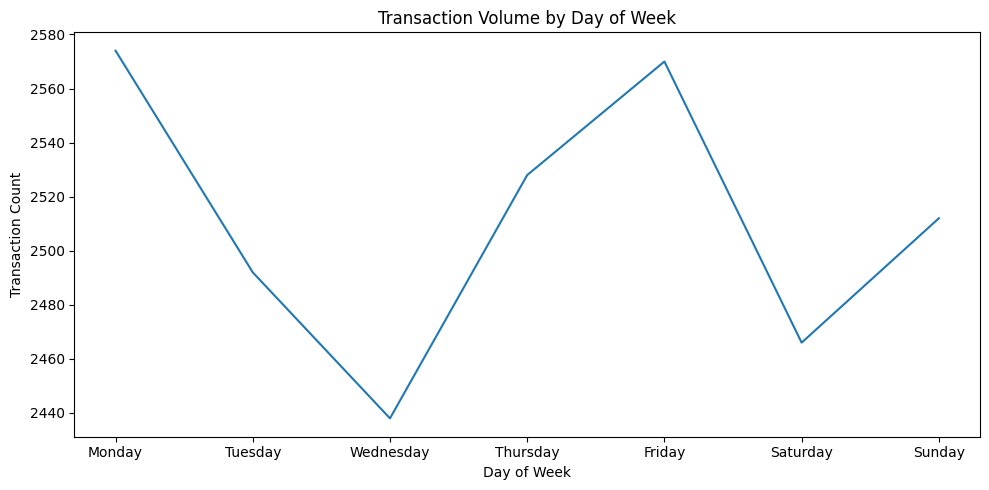

In [65]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)


daily_txn = df['day_of_week'].value_counts().reindex(day_order)

# Peak day
peak_day = daily_txn.idxmax()
print(f" Peak Transaction Day: {peak_day} with {daily_txn.max()} transactions")

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=daily_txn.index, y=daily_txn.values, palette='flare')
plt.title('Transaction Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Transaction Count')
plt.tight_layout()
plt.show()

Monday and Friday have the highest transaction volumes, while Wednesday sees the lowest. Weekends (Saturday and Sunday) maintain moderate activity, with Saturday slightly lower.

Possible Reasons:

-Monday’s high volume may reflect users clearing pending bills or scheduling transfers after the weekend.
-Friday’s peak could be due to weekend preparations—shopping, travel, or food delivery.
-Wednesday’s dip may reflect a midweek lull, where neither personal nor business transactions peak significantly.



## Do Weekends See More P2M (Person to Merchant) Transactions?

In [57]:
df['amount (INR)'] = pd.to_numeric(df['amount (INR)'], errors='coerce')

# Filter only P2M transactions
p2m_df = df[df['transaction type'] == 'P2M']

# Separate into weekdays and weekends
weekday_p2m = p2m_df[p2m_df['is_weekend'] == 0]
weekend_p2m = p2m_df[p2m_df['is_weekend'] == 1]

# Calculate average amount per transaction
avg_weekday_amount = weekday_p2m['amount (INR)'].mean()
avg_weekend_amount = weekend_p2m['amount (INR)'].mean()

# Display results
print(" Average Transaction Amount for P2M Transactions:")
print(f"  Weekdays (Mon–Fri): ₹{avg_weekday_amount:.2f}")
print(f" Weekends (Sat–Sun): ₹{avg_weekend_amount:.2f}")

 Average Transaction Amount for P2M Transactions:
  Weekdays (Mon–Fri): ₹1273.32
 Weekends (Sat–Sun): ₹1305.24


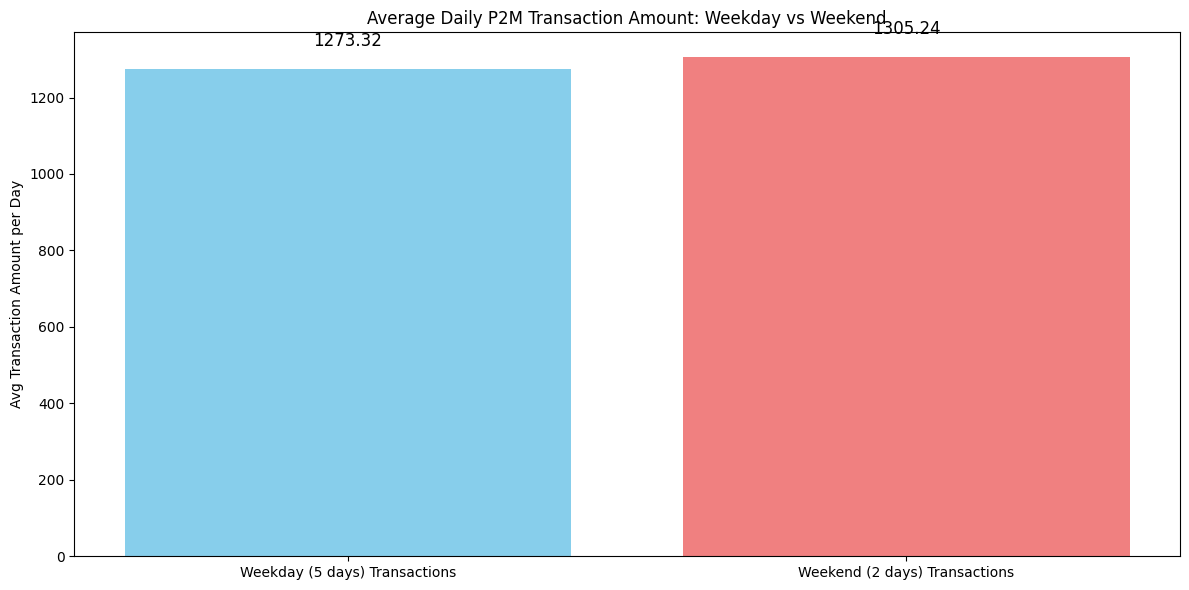

In [58]:
import matplotlib.pyplot as plt

# These are your calculated values
labels = ['Weekday (5 days) Transactions', 'Weekend (2 days) Transactions']
avg_txns = [avg_weekday_amount, avg_weekend_amount]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, avg_txns, color=['skyblue', 'lightcoral'])

# Annotate the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# Titles and labels
plt.title('Average Daily P2M Transaction Amount: Weekday vs Weekend')
plt.ylabel('Avg Transaction Amount per Day')
plt.tight_layout()
plt.show()


The average transaction amount for P2M (Person-to-Merchant) transactions is higher on weekends (₹1,305.24) compared to weekdays (₹1,273.32). This indicates that users tend to make larger purchases or payments during weekends, possibly due to shopping, dining out, or leisure activities, while weekday transactions may involve more frequent but smaller routine expenses.












## hour_of_day vs Transaction Count and Average Amount

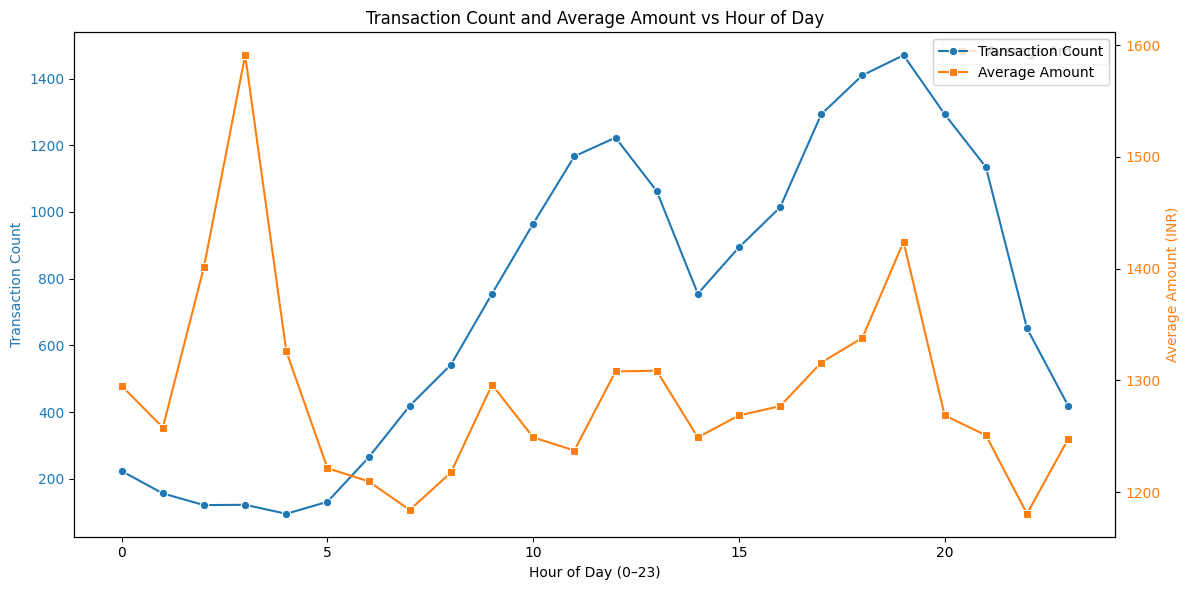

In [59]:
# Group by hour
hourly_stats = df.groupby('hour_of_day').agg(
    txn_count=('transaction id', 'count'),S
    avg_amount=('amount (INR)', 'mean')
).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Lineplot for transaction count
sns.lineplot(data=hourly_stats, x='hour_of_day', y='txn_count', marker='o', ax=ax1, color='tab:blue', label='Transaction Count')
ax1.set_ylabel('Transaction Count', color='tab:blue')
ax1.set_xlabel('Hour of Day (0–23)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Transaction Count and Average Amount vs Hour of Day')

# Twin axis for average amount
ax2 = ax1.twinx()
sns.lineplot(data=hourly_stats, x='hour_of_day', y='avg_amount', marker='s', ax=ax2, color='tab:orange', label='Average Amount')
ax2.set_ylabel('Average Amount (INR)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

The chart shows a clear pattern where transaction count steadily rises from early morning, peaking around 12 PM and again at 8 PM, indicating these are the busiest hours for UPI activity. On the other hand, the average transaction amount spikes at 4 AM, even though transaction count is very low at that time—possibly due to high-value, scheduled, or business-related transfers. During the peak transaction hours, the average amount remains moderate, suggesting that users tend to perform more frequent but smaller transactions during the day, while fewer but larger payments occur at off-peak hours.

This comprehensive analysis of UPI transaction patterns reveals valuable insights into user behavior, fraud trends, and system usage across time, demographics, and platforms. From identifying high-risk time slots and devices to understanding how transaction volume and value vary by age, state, and network, the findings offer actionable direction for fraud prevention, marketing strategies, and operational optimization. As digital payments continue to grow, such data-driven insights are crucial for enhancing security, improving user experience, and supporting smarter business decisions in the evolving fintech landscape.